### importações

In [104]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
import numpy as np
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw, ImageFilter
import glob

cwd = os.getcwd()

BATCH_SIZE = 64
EPOCH_SIZE = 64


### gerar imagens

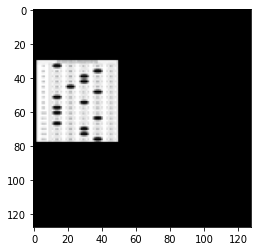

In [96]:
def gabarito_gen(batch_size = 64):
    # pasta das imagens de gabaritos
    source_path = cwd + "\\tests\\"
    image_files = [f for f in glob.glob(source_path + '*.png')]

    while True:
        # gerando imagens pretas no tamanho desejado
        X = np.zeros((batch_size, 128, 128, 3))
        Y = np.zeros((batch_size, 3))

        # preenchendo imagens
        for i in range(batch_size):
            for filepath in image_files:
                # lendo imagem e fazendo resize para (64, 64) e depois convertendo para array de numpy
                gabarito = Image.open(filepath)
                gabarito = gabarito.resize((64, 64))
                imgGabarito = np.asarray(gabarito)
                plt.imshow(imgGabarito)

                # resize no gabarito
                size = np.random.randint(32, 64)
                temp_gabarito = gabarito.resize((size, size))
                imgGabarito = np.asarray(temp_gabarito) / 255.
                gabarito_x, gabarito_y, _ = imgGabarito.shape

                # criar fundo preto da imagem
                bg = Image.new('RGB', (128, 128))

                # processo de geracao
                x1 = np.random.randint(1, 128 - gabarito_x)
                y1 = np.random.randint(1, 128 - gabarito_y)

                # colar imagem do gabarito sobre o fundo preto
                bg.paste(temp_gabarito, (x1, y1))
                # transformando em array de numpy
                gabarito = np.asarray(bg) / 255.
                X[i] = gabarito

                Y[i, 0] = x1 / 128.
                Y[i, 1] = y1 / 128.
                Y[i, 2] = gabarito_x / 128.
        yield X, Y

# chamando funcao de gerar gabaritos
x, y = next(gabarito_gen())

64


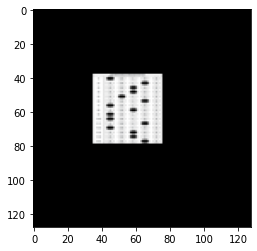

In [100]:
# teste de plotagens
print(len(x))
plt.imshow(x[20])

### buscar imagens geradas

### transferencia de aprendizado - lendo VGG pre-treinada e substituindo cabeçalho

In [101]:
vgg = tf.keras.applications.VGG16(input_shape=[128, 128, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model2.summary()


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

c:\Users\felip\anaconda3\envs\forja\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


### fazendo augumentation das imagens

In [102]:
# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
# 	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
# 	horizontal_flip=True, fill_mode="nearest")

# aug.flow(x, y, BATCH_SIZE)

### treinando modelo

C:\Users\felip\AppData\Local\Temp\ipykernel_10520\2518769339.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model2.fit_generator(gabarito_gen(), steps_per_epoch = EPOCH_SIZE, epochs = 5)


Epoch 1/5
64/64 [==============================] - 1124s 17s/step - loss: 0.6403
Epoch 2/5
64/64 [==============================] - 1108s 17s/step - loss: 0.5751
Epoch 3/5
64/64 [==============================] - 1095s 17s/step - loss: 0.5717
Epoch 4/5
64/64 [==============================] - 1105s 17s/step - loss: 0.5754
Epoch 5/5
64/64 [==============================] - 1094s 17s/step - loss: 0.5731


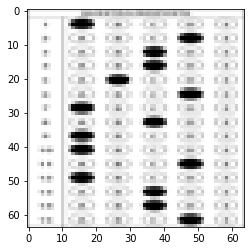

In [103]:
model2.fit_generator(gabarito_gen(), steps_per_epoch = EPOCH_SIZE, epochs = 5)

### predizer a posição do gabarito na imagem

(1, 128, 128, 3)


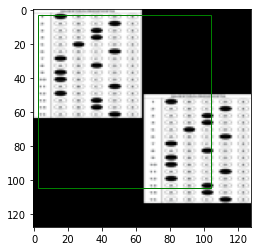

In [140]:
def plot_pred(img, p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy = (p[0] * 128, p[1] * 128), width = p[2] * 128, height = p[2] * 128, linewidth = 1,edgecolor = 'g',facecolor = 'none')
  ax.add_patch(rect)
  plt.show()

# gerar imagem de teste
X = np.zeros((64, 128, 128, 3))
gabarito = Image.open('tests/blog (1).png')
gabarito = gabarito.resize((64, 64))

bg = Image.new('RGB', (128, 128))
bg.paste(gabarito, (0, 0))
bg.paste(gabarito, (65, 50))
gabarito = np.asarray(bg) / 255.
X = gabarito
X = np.expand_dims(X, axis=0)
# x, _ = next(gabarito_gen())
# print(x.shape)
# print(x[0].shape)
print(X.shape)
# plt.imshow(X[0])
pred = model2.predict(X)
plot_pred(X[0], pred[0])

# print(pred)
# img = x[50]
# p = pred[50]
# plot_pred(bg, pred)